In [1]:
import numpy as np
import pandas as pd
import itertools
from matplotlib import pyplot as plt

In [2]:
import pickle

In [16]:
df = pd.read_pickle(r'C:\Users\mi\MLcourse\mlcourse.ai\data\mobile_app_launches_sessions_payments.pkl')

In [20]:
df

{'X_train':          sessions1  sessions2  sessions3  sessions4  sessions5  sessions6  \
 941782           1          1         19         31         61        109   
 466960           1          5          5          5          5          5   
 704609           6         24         39         46         61         66   
 973929           8         18         33         45         52         62   
 973936           0          0          0          0          0          0   
 ...            ...        ...        ...        ...        ...        ...   
 856396           2          2          2          2          2          2   
 1169917          0          0          0          0          1          1   
 1048916          4         35         42         47         71         78   
 992719           2          2          2          2          2          2   
 426086           2          2          2          2          2          2   
 
          sessions7  sessions8  launches1  launches

In [35]:
X_train = df['X_train']
y_train = df['y_train']
X_valid = df['X_valid']
y_valid = df['y_valid']

In [34]:
y_train.mean()

0.0763147680962546

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [37]:
forest = RandomForestClassifier(n_estimators=300, class_weight='balanced', n_jobs=4, random_state=17)

In [39]:
%%time
forest.fit(X_train, y_train)

Wall time: 3min 16s


RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=4,
                       random_state=17)

In [40]:
forest_pred_probs = forest.predict_proba(X_valid)[:, 1]

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

In [42]:
roc_auc_score(y_valid, forest_pred_probs)

0.9644760596195973

In [45]:
accuracy_score(y_valid, X_valid['sum_payments8'] > 0)

0.9879156301560214

In [47]:
accuracy_score(y_valid, forest_pred_probs > 0.5)

0.9857308213692412

In [48]:
y_valid.shape

(353349,)

In [50]:
pred_df = pd.DataFrame({'true': y_valid, 'pred_forest': forest_pred_probs, 
             'pred_baseline': (X_valid['sum_payments8'] > 0).astype('int')})

In [51]:
pred_df.sort_values(by='pred_forest', ascending=False, inplace=True)

In [52]:
pred_df.head(5)

,true,pred_forest,pred_baseline
69935,1,1.0,1
23380,1,1.0,1
33460,1,1.0,1
80701,1,1.0,1
239,1,1.0,1


In [55]:
pred_df.iloc[:50000]['true'].mean() / y_valid.mean()

6.2948480666721

In [61]:
pred_df.sort_values(by='pred_baseline', ascending=False).iloc[:50000]['true'].mean() / y_valid.mean()

5.871773911484229

In [63]:
precision_score(y_valid, forest_pred_probs > 0.5), \
    precision_score(y_valid, X_valid['sum_payments8'] > 0)

(0.9613782658084059, 1.0)

In [64]:
recall_score(y_valid, forest_pred_probs > 0.5), \
    recall_score(y_valid, X_valid['sum_payments8'] > 0)

(0.8277773249653598, 0.825984187790366)

In [68]:
f1_score(y_valid, forest_pred_probs > 0.5), \
    f1_score(y_valid, X_valid['sum_payments8'] > 0)

(0.8895896290456795, 0.904700263357586)

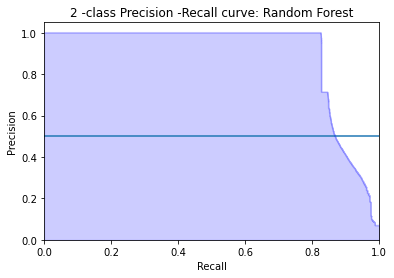

In [77]:
from sklearn.metrics import precision_recall_curve 
#from sklearn.utils.fixes import signature 
from funcsigs import signature
precision, recall, thres = precision_recall_curve(y_valid, forest_pred_probs)
step_kwargs = ({'step': 'post'}
                if 'step' in signature(plt.fill_between).parameters 
                else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.hlines (y=0.5, xmin=0, xmax=1)
plt.xlim( [0.0, 1.0]) 
plt.title ('2 -class Precision -Recall curve: Random Forest');

In [71]:
tau = 0.95
precision_score(y_valid, forest_pred_probs > tau), \
recall_score(y_valid, forest_pred_probs > tau)

(1.0, 0.8240280381449181)

Text(0, 0.5, 'metric')

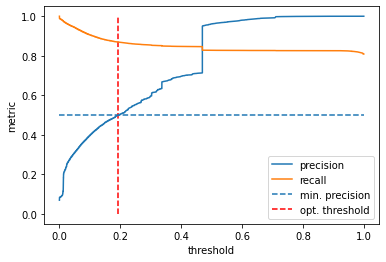

In [81]:
plt.plot(thres, precision[:-1], label='precision')
plt.plot(thres, recall[:-1], label='recall')
plt.hlines(y=0.5, xmin=0, xmax=1, label='min. precision', linestyles='dashed')
plt.vlines(x=0.194, ymin=0, ymax=1, color='red', label='opt. threshold', linestyles='dashed')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('metric')

In [80]:
precision_score(y_valid, forest_pred_probs > 0.194), \
recall_score(y_valid, forest_pred_probs > 0.194)

(0.5011045309268659, 0.8689787268726058)

In [82]:
precision_score(y_valid, X_valid['sum_payments8'] > 0), \
recall_score(y_valid, X_valid['sum_payments8'] > 0)

(1.0, 0.825984187790366)

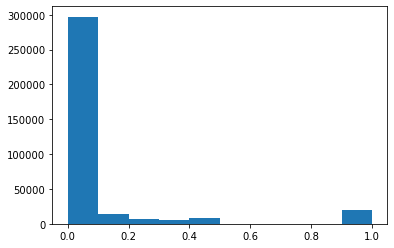

In [84]:
plt.hist(forest_pred_probs);

#### Feature importance

In [90]:
pd.DataFrame(forest.feature_importances_, index=X_train.columns,
             columns=['importance']).sort_values(by='importance', ascending=False)

,importance
num_payments8,0.121069
sum_payments8,0.116459
sum_payments7,0.073057
num_payments7,0.072743
num_payments6,0.062400
sum_payments6,0.043248
launches8,0.040391
sessions8,0.040025
sum_payments5,0.037349
num_payments5,0.033809


In [91]:
from sklearn.metrics import confusion_matrix

In [92]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

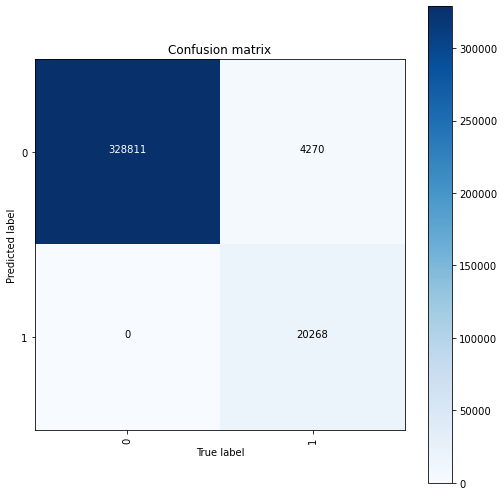

In [93]:
plot_confusion_matrix(actual=y_valid, predicted=X_valid['sum_payments8'] > 0,
                     classes=forest.classes_)

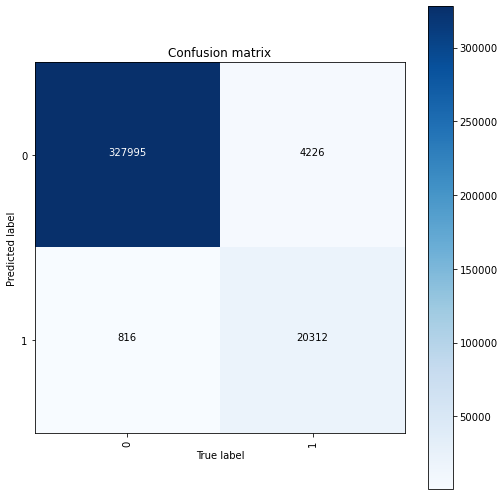

In [94]:
plot_confusion_matrix(actual=y_valid, predicted=(forest_pred_probs > 0.5),
                     classes=forest.classes_)

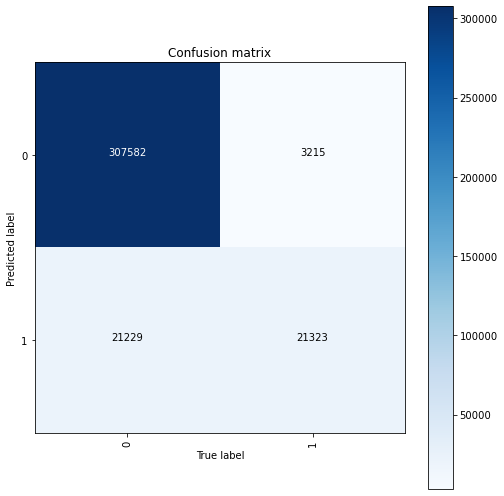

In [95]:
plot_confusion_matrix(actual=y_valid, predicted=(forest_pred_probs > 0.194),
                     classes=forest.classes_)

## Logistic regression

In [96]:
from sklearn.preprocessing import StandardScaler

In [97]:
logit = LogisticRegression(n_jobs=4, random_state=17, 
                           class_weight='balanced', solver='sag')

In [98]:
scaler = StandardScaler()

In [99]:
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [100]:
%%time
logit.fit(X_train_scaled, y_train)

Wall time: 53.2 s


C:\Programming\Anaconda\envs\BigData\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(class_weight='balanced', n_jobs=4, random_state=17,
                   solver='sag')

In [101]:
logit_pred_probs = logit.predict_proba(X_valid_scaled)[:, 1]

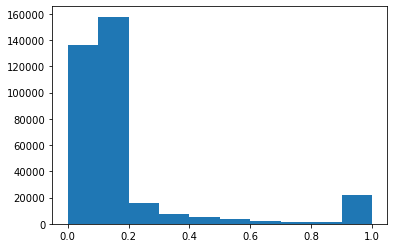

In [102]:
plt.hist(logit_pred_probs);

In [103]:
roc_auc_score(y_valid, logit_pred_probs)

0.9764940094392004